In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import time

In [2]:
def benchmark(f, n: int or float = 10e5, args: tuple = None, kwargs: dict = None) -> np.array:
    if args is None:
        args = ()
    if kwargs is None:
        kwargs = {}
    
    start = time.process_time()
    for _ in range(int(n)):
        f(*args, **kwargs)
    end = time.process_time()
    return (end - start)/n

In [3]:
def test_matmul(f):
    A = np.random.rand(10,2)
    B = np.random.rand(2,5)
    C = np.zeros((A.shape[0], B.shape[1]))
    f(A, B, C)
    return np.max(np.abs(np.dot(A, B) - C))

def benchmark_matmul(f, Ns, n):
    times = []
    for N in Ns:
        A = np.random.rand(N,N)
        B = np.random.rand(N,N)
        C = np.zeros((N, N))
        times.append(benchmark(f, n, args=(A, B, C)))
    return times

In [4]:
class Mul:
    def __init__(self, f):
        self.f = f
        self.ns = []
        self.times = []
        self.name = f.__name__
    
    def burn(self, ns, n):
        print(test_matmul(self.f))
        self.ns = ns
        self.times = benchmark_matmul(self.f, self.ns, n)

In [5]:
def matmul(A, B, C):
    N, M = A.shape
    K = B.shape[1]
    for n in range(N):
        for k in range(K):
            for m in range(M):
                C[n,k] += A[n,m]*B[m,k]

matmul = Mul(matmul)
matmul.burn(np.logspace(1, 2.05, 10, dtype=int), 4)

1.1102230246251565e-16


In [6]:
def matmul_other_order(A, B, C):
    N, M = A.shape
    K = B.shape[1]
    for n in range(N):
        for m in range(M):
            for k in range(K):
                C[n,k] += A[n,m]*B[m,k]

matmul_other_order = Mul(matmul_other_order)
matmul_other_order.burn(np.logspace(1, 2.05, 10, dtype=int), 4)

5.551115123125783e-17


In [7]:
def matmul_sum(A, B, C):
    N, M = A.shape
    K = B.shape[1]
    for n in range(N):
        for k in range(K):
            C[n,k] = np.sum(A[n,:]*B[:,k])

matmul_sum = Mul(matmul_sum)
matmul_sum.burn(np.logspace(1, 2.5, 10, dtype=int), 4)

2.220446049250313e-16


In [8]:
def matmul_numpy(A, B, C):
    C[:,:] = np.dot(A, B)

matmul_numpy = Mul(matmul_numpy)
matmul_numpy.burn(np.logspace(1, 3.35, 10, dtype=int), 10)

0.0


In [9]:
@nb.njit(nb.void(nb.float64[:,:],nb.float64[:,:],nb.float64[:,:]))
def matmul_jit(A, B, C):
    N, M = A.shape
    K = B.shape[1]
    for n in range(N):
        for k in range(K):
            for m in range(M):
                C[n,k] += A[n,m]*B[m,k]

matmul_jit = Mul(matmul_jit)
matmul_jit.burn(np.logspace(1, 2.85, 10, dtype=int), 10)

1.1102230246251565e-16


In [10]:
@nb.njit(nb.void(nb.float64[:,:],nb.float64[:,:],nb.float64[:,:]))
def matmul_jit_other_order(A, B, C):
    N, M = A.shape
    K = B.shape[1]
    for n in range(N):
        for m in range(M):
            for k in range(K):
                C[n,k] += A[n,m]*B[m,k]

matmul_jit_1 = Mul(matmul_jit_other_order)
matmul_jit_1.burn(np.logspace(1, 2.85, 10, dtype=int), 10)

1.1102230246251565e-16


In [11]:
@nb.njit(nb.void(nb.float64[:,:],nb.float64[:,:],nb.float64[:,:]), parallel=True)
def matmul_jit_other_order_p(A, B, C):
    N, M = A.shape
    K = B.shape[1]
    for n in nb.prange(N):
        for m in nb.prange(M):
            for k in nb.prange(K):     
                C[n,k] += A[n,m] * B[m,k]


matmul_jit_p = Mul(matmul_jit_other_order_p)
matmul_jit_p.burn(np.logspace(1, 2.85, 10, dtype=int), 10)

1.1102230246251565e-16


In [15]:
@nb.njit(nb.void(nb.float64[:,:],nb.float64[:,:],nb.float64[:,:]), parallel=True, nogil=True, cache=True, )
def matmul_test(A, B, C):
    N, M = A.shape
    K = B.shape[1]
    B = B.T
    for n in range(N):
        for m in nb.prange(M):
            for k in nb.prange(K):
                C[n,k] += A[n,m]*B[k,m]
            

matmul_test = Mul(matmul_test)
matmul_test.burn(np.logspace(1, 2.85, 10, dtype=int), 10)

1.1102230246251565e-16


In [13]:
matmul_test.f.parallel_diagnostics(level=4)

 
 Parallel Accelerator Optimizing:  Function matmul_test, <ipython-
input-12-4782993f7528> (1)  


Parallel loop listing for  Function matmul_test, <ipython-input-12-4782993f7528> (1) 
---------------------------------------------------------------------------------------------------------------|loop #ID
@nb.njit(nb.void(nb.float64[:,:],nb.float64[:,:],nb.float64[:,:]), parallel=True, nogil=True, cache=True, )    | 
def matmul_test(A, B, C):                                                                                      | 
    N, M = A.shape                                                                                             | 
    K = B.shape[1]                                                                                             | 
    B = B.T                                                                                                    | 
    for n in nb.prange(N):-------------------------------------------------------------------------------------| #5
       

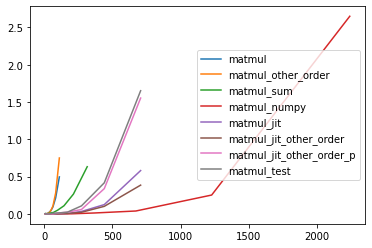

In [16]:
for m in [matmul, matmul_other_order, matmul_sum, matmul_numpy, matmul_jit, matmul_jit_1, matmul_jit_p, matmul_test]:
    plt.plot(m.ns, m.times, label=m.name)
plt.legend()

In [ ]:
from numba import set_num_threads
result_x = []
result_y = []
for num in [1,2,3,4]:
    set_num_threads = num
    
    @nb.njit(nb.void(nb.float64[:,:],nb.float64[:,:],nb.float64[:,:]))
    def matmul_(A, B, C):
        N, M = A.shape
        K = B.shape[1]
        for n in nb.prange(N):
            for k in nb.prange(K):
                for m in nb.prange(M):
                    C[n,k] += A[n,m]*B[m,k]

    matmul_ = Mul(matmul_)
    matmul_.burn(np.linspace(100, 1000, 30, dtype=int), 5)
    result_x.append(matmul_.ns)
    result_y.append(matmul_.times)

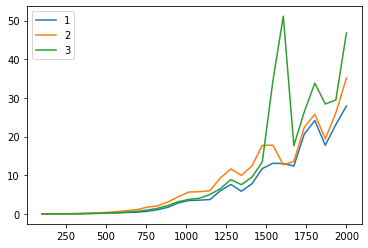

In [36]:
for i in range(len(result_x)):
    plt.plot(result_x[i],result_y[i], label=i+1)
# plt.yscale('log')
plt.legend()